In [1]:
include("../src/GaPSE.jl");

In [20]:
using DelimitedFiles, Plots, Dierckx, QuadGK, SpecialFunctions
using TwoFAST, LaTeXStrings, LsqFit, MaximumLikelihoodPower

In [3]:
tab_pk = readdlm("file_pk.txt", comments=true);
ks = convert(Vector{Float64}, tab_pk[:,1]);
k_min, k_max = ks[begin], ks[end]
pks = convert(Vector{Float64}, tab_pk[:,2]);
PK = Spline1D(ks, pks);

\begin{equation}
    \tilde{I}^4_0 (s) = \int \frac{dq}{2\pi^2} q^2P(q) \frac{j_0(qs) - 1}{(qs)^4}
\end{equation}

In [5]:
function func_I04_tilde(PK, s, kmin, kmax; kwargs...)
     res = quadgk(lq -> (sphericalbesselj(0, s * exp(lq)) - 1.0) * PK(exp(lq)) / (2.0 * π^2 * exp(lq)),
          log(kmin), log(kmax); kwargs...)[1]

     return res / (s^4)
end

function expanded_I04_tilde(PK, ss, kmin, kmax; kwargs...)

     fit_1, fit_2 = 0.1, 10.0
     fit_3, fit_4 = 300.0, 1000.0
    
    if all(fit_1 .< ss .< fit_4)
        return [func_I04_tilde(PK, s, kmin, kmax; kwargs...) for s in ss]
        
    elseif all(ss .> fit_1)
        cutted_ss = ss[ss .< fit_4]
        cutted_I04_tildes = [func_I04_tilde(PK, s, kmin, kmax; kwargs...) for s in cutted_ss]
        r_si, r_b, r_a = GaPSE.power_law_from_data(cutted_ss, cutted_I04_tildes,
             [-4.0, 1.0, 0.0], fit_3, fit_4; con = true)
        println("r_si, r_b, r_a = $r_si , $r_b , $r_a")
        right_I04_tildes = [GaPSE.power_law(s, r_si, r_b, r_a) for s in ss[ss.>=fit_4]]

        return vcat(cutted_I04_tildes, right_I04_tildes)
        
    elseif all(ss .< fit_4)
        cutted_ss = ss[ss .> fit_1]
        cutted_I04_tildes = [func_I04_tilde(PK, s, kmin, kmax; kwargs...) for s in cutted_ss]
        l_si, l_b, l_a = GaPSE.power_law_from_data(cutted_ss, cutted_I04_tildes,
          [-2.0, 1.0, 0.0], fit_1, fit_2; con = true)
        println("l_si, l_b, l_a = $l_si , $l_b , $l_a")
        left_I04_tildes = [GaPSE.power_law(s, l_si, l_b, l_a) for s in ss[ss.<=fit_1]]
        
        return vcat(left_I04_tildes, cutted_I04_tildes)
        
    else
        cutted_ss = ss[fit_1 .< ss .< fit_4]
        cutted_I04_tildes = [func_I04_tilde(PK, s, kmin, kmax; kwargs...) for s in cutted_ss]

        l_si, l_b, l_a = GaPSE.power_law_from_data(cutted_ss, cutted_I04_tildes,
          [-2.0, 1.0, 0.0], fit_1, fit_2; con = true)
        println("l_si, l_b, l_a = $l_si , $l_b , $l_a")
        r_si, r_b, r_a = GaPSE.power_law_from_data(cutted_ss, cutted_I04_tildes,
         [-4.0, 1.0, 0.0], fit_3, fit_4; con = true)
        println("r_si, r_b, r_a = $r_si , $r_b , $r_a")
        left_I04_tildes = [GaPSE.power_law(s, l_si, l_b, l_a) for s in ss[ss.<=fit_1]]
        right_I04_tildes = [GaPSE.power_law(s, r_si, r_b, r_a) for s in ss[ss.>=fit_4]]

        I04_tildes = vcat(left_I04_tildes, cutted_I04_tildes, right_I04_tildes)

        return I04_tildes  
    end
end

expanded_I04_tilde (generic function with 1 method)

In [ ]:
tab_mattia_I04_tildes = readdlm("/Users/matteofoglieni/Dropbox/GR_effects/Mattia_Output/I40_tilde.txt");
mattia_I04_ss = convert(Vector{Float64}, tab_mattia_I04_tildes[2:end,1]);
mattia_I04_tildes = convert(Vector{Float64}, tab_mattia_I04_tildes[2:end,2]);
my_I04_tildes = expanded_I04_tilde(PK, mattia_I04_ss, k_min, k_max);

In [ ]:
xs = mattia_I04_ss
ys = -mattia_I04_tildes
#spline = cosmo.tools.I04_tilde
my_ys = -my_I04_tildes

p1 = plot([xs[my_ys .>0], xs], [my_ys[my_ys .>0],  ys], xaxis=:log, yaxis=:log, 
    lc=[:red :blue], 
    label=["My I04t" "Mattia I04t"], ls=[:dash :solid], legend=:topleft)

p2 = plot(xs, my_ys .- ys, 
    xaxis=:log,label="Difference", lc=:green, legend=:bottomright)
p3 = plot(xs, my_ys ./ ys, label="Ratio", lc=:green, xaxis=:log, ylim=(0.99, 1.01))

plot(p1, p2, p3, size=(650, 600), layout= @layout [ x ; y z ] )

In [ ]:
xs = 10 .^ range(1, 5, length=100)
ys = expanded_I04_tilde(PK, xs, k_min, k_max)
plot(xs[-ys .>0], -ys[-ys .>0], xaxis=:log, yaxis=:log
    )

In [6]:
xs = 10 .^ range(3,4, length=100)
ys = [func_I04_tilde(PK, x, k_min, k_max) for x in xs]
#GaPSE.power_law_from_data(xs, ys, [-4.0, -1.0]; con=false)
GaPSE.mean_spectral_index(xs, ys; N=3, con=false)

-3.701410210979164

In [11]:
GaPSE.power_law_b_a(xs, ys, -3.7014, [-124.0]; con=false)

2-element Vector{Float64}:
 -124.0
    0.0

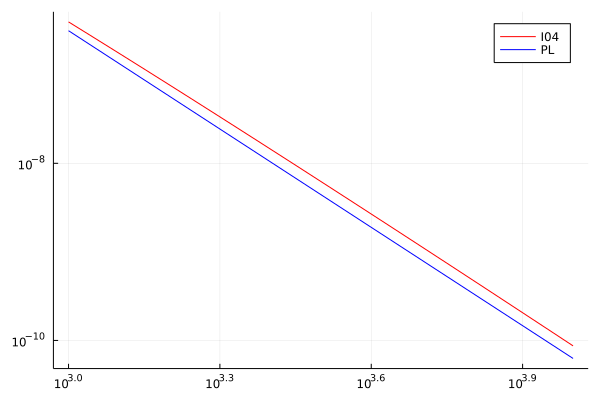

In [36]:
pl_ys = [GaPSE.power_law(x, -3.7014, -40000.0, 0.0) for x in xs]
plot([xs, xs], [-ys, -pl_ys], xaxis=:log, yaxis=:log, lc=[:red :blue],
    label=["I04" "PL"])

In [37]:
?curve_fit

search: curve_fit



```
curve_fit(model, xdata, ydata, p0) -> fit
```

Fit data to a non-linear `model`. `p0` is an initial model parameter guess (see Example). The return object is a composite type (`LsqFitResult`), with some interesting values:

  * `fit.resid` : residuals = vector of residuals
  * `fit.jacobian` : estimated Jacobian at solution

additionally, it is possible to quiry the degrees of freedom with

  * `dof(fit)`
  * `coef(fit)`

## Example

```julia
# a two-parameter exponential model
# x: array of independent variables
# p: array of model parameters
model(x, p) = p[1]*exp.(-x.*p[2])

# some example data
# xdata: independent variables
# ydata: dependent variable
xdata = range(0, stop=10, length=20)
ydata = model(xdata, [1.0 2.0]) + 0.01*randn(length(xdata))
p0 = [0.5, 0.5]

fit = curve_fit(model, xdata, ydata, p0)
```


In [47]:
model(x, p) = p[1] .+ p[2]* x.^(-3.7014)

model (generic function with 1 method)

In [64]:
fit = curve_fit(model, xs, -1.0.*1e7 .* ys, [0.0, -1.0])

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([0.010775763982382957, 5.101964563893176e11], [0.06858213621152975, 0.0487051071687179, 0.031975788792179216, 0.017987899183466105, 0.006382372043951978, -0.003157272014016499, -0.010910184729128414, -0.01712192105420396, -0.022008468156046845, -0.02575937705811948  …  0.010607509121431467, 0.010622929222623072, 0.010636997773516805, 0.010649828662567508, 0.010661526075668934, 0.010672186000882308, 0.010681896629920206, 0.010690739015139868, 0.010698787461971193, 0.010706110376367328], [1.0000000000235538 7.866834251665311e-12; 1.0000000000235538 7.2179209469308915e-12; … ; 1.000000000000063 1.7052492956842844e-15; 1.000000000000063 1.5645880181527161e-15], true, Float64[])

In [65]:
coef(fit)

2-element Vector{Float64}:
 0.010775763982382957
 5.101964563893176e11